## Imports and Set up

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
from scipy import integrate, signal
import sympy

In [2]:
# Set font size of plot elements\n",
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Functions

In [3]:
def photons_from_temp(ω_c, temp):
    hbar_ov_k = 7.639e-12
    return (np.exp(hbar_ov_k * ω_c / temp) - 1) ** -1

In [4]:
def temp_from_photons(ω_c, num_photons):
    hbar_ov_k = 7.639e-12 
    return hbar_ov_k * ω_c / np.log(1 / num_photons + 1)

In [5]:
def get_photons_a_no_NV(ω_bounds, κ, γ, ϕ, nT, β, Sϕ):
    """
    function for calculating the number of phonts in output a (i.e. reflection) when the NV ensemble is not connected
    :param ω_bounds:  the frequency bounds to use for integration
    :param κ:         the output coupling rate on port a
    :param γ:         the internal loss rate of the cavity
    :param ϕ:         the output coupling rate on port e
    :param nT:        the number of thermal photons from the environment
    :param β:         the square root of the amplitude of the coherent input
    :param Sϕ:        the phase noise power spectral density
    :return:          the number of noise photons, signal photons, and total photons
    """
    # Noise part first
    den = np.abs((κ + γ + ϕ) / 2 - 1j * ω_bounds) ** 2
    noise_term = (κ * γ * nT + κ * ϕ + np.abs((κ - γ - ϕ) / 2 + 1j * ω_bounds) ** 2 * nT) / den
    noise_photons = integrate.simpson(noise_term, x=ω_bounds)

    phase_noise_photons = integrate.simpson(np.abs((κ - γ - ϕ) / 2 + 1j * ω_bounds) ** 2  / den * Sϕ, x=ω_bounds)

    noise_photons += phase_noise_photons

    # Now signal term
    signal_photons = np.abs((κ - γ - ϕ) / 2) ** 2  / np.abs((κ + γ + ϕ) / 2) ** 2 * np.abs(β) ** 2

    return noise_photons, signal_photons, noise_photons + signal_photons

In [6]:
def get_photons_e_no_NV(ω_bounds, κ, γ, ϕ, nT, β, Sϕ):
    """
    function for calculating the number of photons in output e (i.e. transmission) when the NV ensemble is not connected
    :param ω_bounds:  the frequency bounds to use for integration
    :param κ:         the output coupling rate on port a
    :param γ:         the internal loss rate of the cavity
    :param ϕ:         the output coupling rate on port e
    :param nT:        the number of thermal photons from the environment
    :param β:         the square root of the amplitude of the coherent input
    :param Sϕ:        the phase noise power spectral density
    :return:          the number of noise photons, signal photons, and total photons
    """
    # Noise part first
    den = np.abs((κ + γ + ϕ) / 2 - 1j * ω_bounds) ** 2
    noise_term = (ϕ * κ * nT + ϕ * γ * nT + np.abs((ϕ - κ - γ) / 2 + 1j * ω_bounds) ** 2) / den
    noise_photons = integrate.simpson(noise_term, x=ω_bounds)

    phase_noise_photons = integrate.simpson(ϕ * κ  / np.abs((κ + γ + ϕ) / 2 - 1j * ω_bounds) ** 2 * Sϕ, x=ω_bounds)

    noise_photons += phase_noise_photons

    # Now signal term
    signal_photons = ϕ * κ  / np.abs((κ + γ + ϕ) / 2) ** 2 * np.abs(β) ** 2

    return noise_photons, signal_photons, noise_photons + signal_photons

In [7]:
def get_photons_b_no_NV(ω_bounds, κ, γ, ϕ, nT, β, Sϕ):
    """
    function for calculating the number of photons lost to internal cavity loss when the Nv ensemble is not connected
    """
    den = np.abs((κ + γ + ϕ) / 2 - 1j * ω_bounds) ** 2
    noise_term = (γ * κ * nT + γ * ϕ + np.abs((γ - κ - ϕ) / 2 - 1j * ω_bounds) ** 2 * nT) / den
    noise_photons = integrate.simpson(noise_term, x=ω_bounds)

    phase_noise_photons = integrate.simpson(γ * κ / np.abs((κ + γ + ϕ) / 2 - 1j * ω_bounds) ** 2 * Sϕ)

    noise_photons += phase_noise_photons

    signal_photons = γ * κ / np.abs((κ + γ + ϕ) / 2 - 1j * 0) ** 2 * np.abs(β) ** 2

    return noise_photons, signal_photons, noise_photons + signal_photons

In [8]:
def get_photons_a(ω_bounds, κ, γ, ϕ, g, r, nT, nc, β, Sϕ):
    """
    function for calculating the number of phonts in output a (i.e. reflection) when the NV ensemble is connected
    :param ω_bounds:  the frequency bounds to use for integration
    :param κ:         the output coupling rate on port a
    :param γ:         the internal loss rate of the cavity
    :param ϕ:         the output coupling rate on port e
    :param g:         the collective coupling strength between the cavity and the ensemble
    :param r:         the inhomogenous broadening of the spins
    :param nT:        the number of thermal photons from the environment
    :param nc:        the effective number of photons from the cold spin ensemble
    :param β:         the square root of the amplitude of the coherent input
    :param Sϕ:        the phase noise power spectral density
    :return:          the number of noise photons, signal photons, and total photons
    """
    # To do the integration, we have to separate out the β term
    β_term = np.abs(((κ - γ - ϕ) / 2) * (r / 2) - g ** 2) ** 2 / np.abs(((κ + γ + ϕ) / 2) * (r / 2) + g ** 2) ** 2 * np.abs(β) ** 2
    
    # Now set up the rest
    num = (r ** 2 / 4 + ω_bounds ** 2) * (κ * γ * nT + κ * ϕ) + κ * r * g ** 2 * nc
    num += np.abs(((κ - γ - ϕ) / 2 + 1j * ω_bounds) * (r / 2 - 1j * ω_bounds) - g ** 2) ** 2 * nT

    den = np.abs(((κ + γ + ϕ) / 2 - 1j * ω_bounds) * (r / 2 - 1j * ω_bounds) + g ** 2) ** 2

    noise_term = integrate.simpson(num / den, x=ω_bounds) 
    noise_term += integrate.simpson(np.abs(((κ - γ - ϕ) / 2 + 1j * ω_bounds) * (r / 2 - 1j * ω_bounds) - g ** 2) ** 2 / den * Sϕ, x=ω_bounds)

    return noise_term, β_term, noise_term + β_term

In [9]:
def get_photons_e(ω_bounds, κ, γ, ϕ, g, r, nT, nc, β, Sϕ):
    """
    function for calculating the number of phonts in output a (i.e. reflection) when the NV ensemble is connected
    :param ω_bounds:  the frequency bounds to use for integration
    :param κ:         the output coupling rate on port a
    :param γ:         the internal loss rate of the cavity
    :param ϕ:         the output coupling rate on port e
    :param g:         the collective coupling strength between the cavity and the ensemble
    :param r:         the inhomogenous broadening of the spins
    :param nT:        the number of thermal photons from the environment
    :param nc:        the effective number of photons from the cold spin ensemble
    :param β:         the square root of the amplitude of the coherent input
    :param Sϕ:        the phase noise power spectral density
    :return:          the number of noise photons, signal photons, and total photons
    """
    # To do the integration, we need to separate out the β term
    β_term = (r ** 2 / 4) * ϕ * κ / np.abs(((κ + γ + ϕ) / 2) * (r / 2) + g ** 2) ** 2 * np.abs(β) ** 2

    # Now do the rest
    num = (r ** 2 / 4 + ω_bounds ** 2) * (ϕ * κ * nT + ϕ * γ * nT) + ϕ * r * g ** 2 * nc
    num += np.abs(((ϕ - κ - γ) / 2 + 1j * ω_bounds) * (r / 2 - 1j * ω_bounds) - g ** 2) ** 2
    den = np.abs(((κ + γ + ϕ) / 2 - 1j * ω_bounds) * (r / 2 - 1j * ω_bounds) + g ** 2) ** 2

    noise_term = integrate.simpson(num / den, x=ω_bounds) 
    noise_term += integrate.simpson((r ** 2 / 4 + ω_bounds ** 2) * ϕ * κ / den * Sϕ, x=ω_bounds)
    
    return noise_term, β_term, noise_term + β_term

In [10]:
def get_photons_b(ω_bounds, κ, γ, ϕ, g, r, nT, nc, β, Sϕ):
    β_term = (r ** 2 / 4) * γ * κ / np.abs(((κ + γ + ϕ) / 2) * (r / 2) + g ** 2) ** 2 * np.abs(β) ** 2

    num = (r ** 2 / 4 + ω_bounds ** 2) * (γ * κ * nT + γ * ϕ) + γ * r * g ** 2 * nc
    num += np.abs(((γ - κ - ϕ) / 2 + 1j * ω_bounds) * (r / 2 - 1j * ω_bounds) - g ** 2) ** 2 * nT

    den = np.abs(((κ + γ + ϕ) / 2 - 1j * ω_bounds) * (r / 2 - 1j * ω_bounds) + g ** 2) ** 2

    noise_term = integrate.simpson(num / den, x=ω_bounds)
    noise_term += integrate.simpson((r ** 2 / 4 + ω_bounds ** 2) * γ * κ / den * Sϕ, x=ω_bounds)

    return noise_term, β_term, noise_term + β_term

In [11]:
def get_photons_c(ω_bounds, κ, γ, ϕ, g, r, nT, nc, β, Sϕ):
    β_term = r * κ * g ** 2 / np.abs(((κ + γ + ϕ) / 2) * (r / 2) + g ** 2) ** 2 * np.abs(β) ** 2

    num = r * κ * g ** 2 * nT + r * γ * g ** 2 * nT + r * ϕ * g ** 2
    num += np.abs(((κ + γ + ϕ) / 2 - 1j * ω_bounds) * (r / 2 + 1j * ω_bounds) - g ** 2) ** 2 * nc

    den = np.abs(((κ + γ + ϕ) / 2 - 1j * ω_bounds) * (r / 2 - 1j * ω_bounds) + g ** 2) ** 2

    noise_term = integrate.simpson(num / den, x=ω_bounds)
    noise_term += integrate.simpson(r * κ * g ** 2 / den * Sϕ, x=ω_bounds)

    return noise_term, β_term, noise_term + β_term

In [12]:
def get_output_spectrum_e(ω, κ, γ, ϕ, g, r, nT, nc, β, Sϕ):
    # Going to ignore β for now because we're just looking at the noise
    a = (r ** 2 / 4 + ω ** 2) * (ϕ * κ * nT + ϕ * γ * nT) + ϕ * r * g ** 2 * nc
    b = np.abs(((ϕ - κ - γ) / 2 + 1j * ω) * (r / 2 - 1j * ω) - g ** 2) ** 2
    c = (r ** 2 / 4 + ω ** 2) * ϕ * κ * (np.abs(β) ** 2 + Sϕ)

    den = np.abs(((κ + γ + ϕ) / 2 - 1j * ω) * (r / 2 - 1j * ω) + g ** 2) ** 2

    return (a + b + c) / den

In [13]:
def get_output_noise_spectrum_e(ω, κ, γ, ϕ, g, r, nT, nc, β, Sϕ):
    a = (r ** 2 / 4 + ω ** 2) * (ϕ * κ * nT + ϕ * γ * nT) + ϕ * r * g ** 2 * nc
    b = np.abs(((ϕ - κ - γ) / 2 + 1j * ω) * (r / 2 - 1j * ω) - g ** 2) ** 2

    den = np.abs(((κ + γ + ϕ) / 2 - 1j * ω) * (r / 2 - 1j * ω) + g ** 2) ** 2

    return (a + b) / den + (r ** 2 / 4 + ω ** 2) * ϕ * κ / den * Sϕ

In [14]:
def get_output_signal_spectrum_e(ω, κ, γ, ϕ, g, r, nT, nc, β):
    c = (r ** 2 / 4 + ω ** 2) * ϕ * κ * np.abs(β) ** 2

    den = np.abs(((κ + γ + ϕ) / 2 - 1j * ω) * (r / 2 - 1j * ω) + g ** 2) ** 2

    return c / den

In [15]:
def get_output_spectrum_e_no_NV(ω, κ, γ, ϕ, nT, β, Sϕ):
    a = ϕ * κ * nT + ϕ * γ * nT
    b = np.abs((ϕ - κ - γ) / 2 + 1j * ω) ** 2
    c = ϕ * κ * (np.abs(β) ** 2 + Sϕ)

    den = np.abs((κ + γ + ϕ) / 2 - 1j * ω) ** 2

    return (a + b + c) / den

In [16]:
def get_output_noise_spectrum_e_no_NV(ω, κ, γ, ϕ, nT, β, Sϕ):
    a = ϕ * κ * nT + ϕ * γ * nT
    b = np.abs((ϕ - κ - γ) / 2 + 1j * ω) ** 2

    den = np.abs((κ + γ + ϕ) / 2 - 1j * ω) ** 2

    return (a + b) / den + ϕ * κ / den * Sϕ

In [17]:
def get_output_signal_spectrum_e_no_NV(ω, κ, γ, ϕ, nT, β):
    c = ϕ * κ * np.abs(β) ** 2

    den = np.abs((κ + γ + ϕ) / 2 - 1j * ω) ** 2

    return c / den

## Calculations

In [18]:
# Define parameters
ωc = 2.87 * 2 * np.pi * 1e9
g = 2 * np.pi * 197.7e3
r = 2 * np.pi * 229e3
γ = 2 * np.pi * 140e3
κ = 2 * np.pi * 185.1e3
P = 0.8
nc = 0.5 * (1 - P) / P
T = 5
nT = photons_from_temp(ωc, T)
ϕ = (κ + γ) / 2
β = np.sqrt(1e10)

# Set the power spectral density for the phase noise to a constant - we'll use half of nT for now
ω_bounds = np.linspace(-γ, γ, 1000)
Sϕ = nT / 2 * np.ones(ω_bounds.shape[0])

### a) How does SNR compare between the two as $\beta$ changes?

In [19]:
# First set up β range
β_vals = np.sqrt(np.logspace(6, 10, 1000))

# Define bounds on ω
ω_bounds = np.linspace(-γ, γ, 1000)

In [20]:
# Calculate the input noise using γ as the linewidth
input_noise = (ω_bounds[-1] - ω_bounds[0]) * (2*nT+1)
input_noise += integrate.simpson(Sϕ, x=ω_bounds)

# Calculate the input signal from the β values
input_signal_vals = np.abs(β_vals) ** 2

# Calculate the initial SNR - this will be the same for both cavity configurations
input_snr_vals = input_signal_vals / input_noise

In [21]:
# Calculate the output noise and signal for the cavity with no NV ensemble
output_noise_no_nv_vals = []
output_signal_no_nv_vals = []
for b in β_vals:
    temp = get_photons_e_no_NV(ω_bounds, κ, γ, ϕ, nT, b, Sϕ)
    output_noise_no_nv_vals.append(temp[0])
    output_signal_no_nv_vals.append(temp[1])

output_noise_no_nv_vals = np.array(output_noise_no_nv_vals)
output_signal_no_nv_vals = np.array(output_signal_no_nv_vals)
output_snr_no_nv_vals = output_signal_no_nv_vals / output_noise_no_nv_vals

In [22]:
# Calculate the output noise and signal for the cavity with the NV ensemble
output_noise_vals = []
output_signal_vals = []
for b in β_vals:
    temp = get_photons_e(ω_bounds, κ, γ, ϕ, g, r, nT, nc, b, Sϕ)
    output_noise_vals.append(temp[0])
    output_signal_vals.append(temp[1])

output_noise_vals = np.array(output_noise_vals)
output_signal_vals = np.array(output_signal_vals)
output_snr_vals = output_signal_vals / output_noise_vals

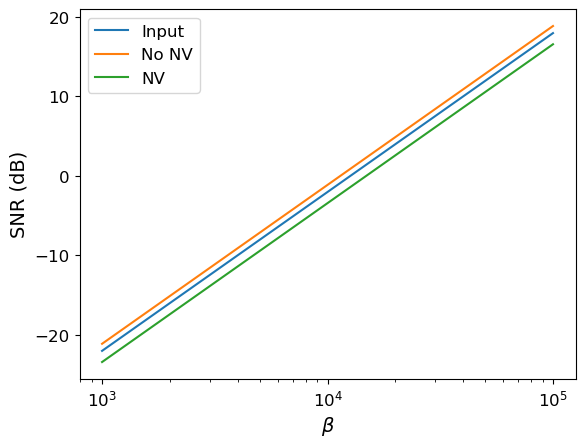

In [23]:
plt.plot(β_vals, 10*np.log10(input_snr_vals), label='Input')
plt.plot(β_vals, 10*np.log10(output_snr_no_nv_vals), label='No NV')
plt.plot(β_vals, 10*np.log10(output_snr_vals), label='NV')
plt.xlabel("$\\beta$")
plt.ylabel("SNR (dB)")
plt.xscale('log')
plt.legend()

### b) What about $\kappa$?

Text(0.5, 0, '$\\omega$ (MHz)')

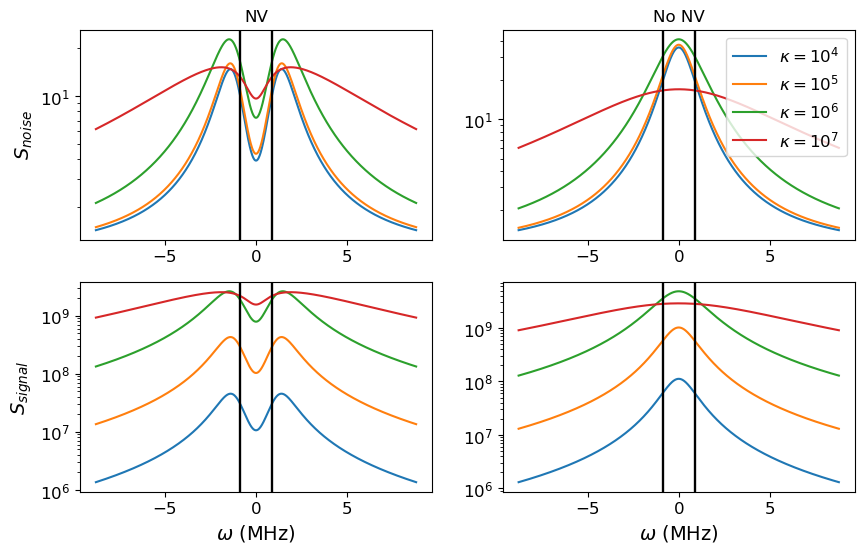

In [24]:
# Let's look at the spectra first
κ_vals = [1e4, 1e5, 1e6, 1e7]
s_noise_out_vals = []
s_signal_out_vals = []
s_noise_out_no_NV_vals = []
s_signal_out_no_NV_vals = []
for k in κ_vals:
    s_noise_out_vals.append(get_output_noise_spectrum_e(10*ω_bounds, k, γ, ϕ, g, r, nT, nc, β, Sϕ))
    s_signal_out_vals.append(get_output_signal_spectrum_e(10*ω_bounds, k, γ, ϕ, g, r, nT, nc, β))
    s_noise_out_no_NV_vals.append(get_output_noise_spectrum_e_no_NV(10*ω_bounds, k, γ, ϕ, nT, β, Sϕ))
    s_signal_out_no_NV_vals.append(get_output_signal_spectrum_e_no_NV(10*ω_bounds, k, γ, ϕ, nT, β))

#linestyles = ['-', (0, (5, 10)), (0, (5, 7.5)), (0, (5, 5)), (0, (5, 2.5))] 
linestyles = ['-', '-', '-', '-']
fig = plt.figure(1, figsize=(10, 6))
ax = fig.subplots(2, 2)
for i, k in enumerate(κ_vals):
    ax[0][0].semilogy(10*ω_bounds / 1e6, s_noise_out_vals[i], linestyle=linestyles[i])
    ax[0][0].axvline(x=-γ/1e6, color='k')
    ax[0][0].axvline(x=γ/1e6, color='k')

    ax[0][1].semilogy(10*ω_bounds / 1e6, s_noise_out_no_NV_vals[i], linestyle=linestyles[i], label='$\\kappa = 10^{' + str(i+4) + '}$')
    ax[0][1].axvline(x=-γ/1e6, color='k')
    ax[0][1].axvline(x=γ/1e6, color='k')

    ax[1][0].semilogy(10*ω_bounds / 1e6, s_signal_out_vals[i], linestyle=linestyles[i])
    ax[1][0].axvline(x=-γ/1e6, color='k')
    ax[1][0].axvline(x=γ/1e6, color='k')

    ax[1][1].semilogy(10*ω_bounds / 1e6, s_signal_out_no_NV_vals[i], linestyle=linestyles[i])
    ax[1][1].axvline(x=-γ/1e6, color='k')
    ax[1][1].axvline(x=γ/1e6, color='k')

ax[0][0].set_ylabel("$S_{noise}$")
ax[0][0].set_title("NV")
ax[0][1].set_title("No NV")
ax[0][1].legend()
ax[1][0].set_ylabel("$S_{signal}$")
ax[1][0].set_xlabel("$\\omega$ (MHz)")
ax[1][1].set_xlabel("$\\omega$ (MHz)")

In [25]:
# Define κ values
κ_vals = np.logspace(4, 7, 1000)

In [26]:
# Define the input noise
input_noise = (ω_bounds[-1] - ω_bounds[0]) * (nT + nT + 1)
input_noise += integrate.simpson(Sϕ, x=ω_bounds)

# Define the input signal
input_signal = np.abs(β) ** 2

# Calculate the input snr
input_snr = input_signal / input_noise

In [27]:
# Calculate the output noise and signal for each κ value with no NV ensemble
output_noise_no_NV_vals = np.zeros(κ_vals.shape[0])
output_signal_no_NV_vals = np.zeros(κ_vals.shape[0])
for i, k in enumerate(κ_vals):
    temp = get_photons_e_no_NV(ω_bounds, k, γ, ϕ, nT, β, Sϕ)
    output_noise_no_NV_vals[i] = temp[0]
    output_signal_no_NV_vals[i] = temp[1]

# Calculate SNR
output_snr_no_NV_vals = output_signal_no_NV_vals / output_noise_no_NV_vals

In [28]:
# Calculate the output noise and signal for each κ value with NV ensemble
output_noise_vals = np.zeros(κ_vals.shape[0])
output_signal_vals = np.zeros(κ_vals.shape[0])
for i, k in enumerate(κ_vals):
    temp = get_photons_e(ω_bounds, k, γ, ϕ, g, r, nT, nc, β, Sϕ)
    output_noise_vals[i] = temp[0]
    output_signal_vals[i] = temp[1]

# Calculate SNR
output_snr_vals = output_signal_vals / output_noise_vals

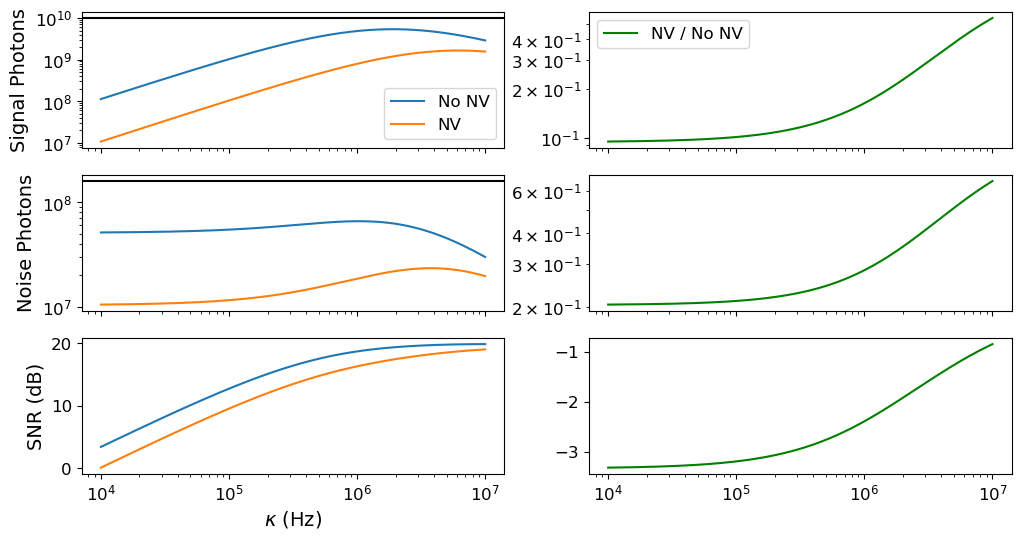

In [29]:
# Plot
fig = plt.figure(1, figsize=(12,6))
ax = fig.subplots(3, 2, sharex='all')
ax[0][0].semilogx(κ_vals, output_signal_no_NV_vals, label='No NV')
ax[0][0].semilogx(κ_vals, output_signal_vals, label='NV')
ax[0][0].axhline(y=np.abs(β) ** 2, color='k')
ax[0][0].set_ylabel("Signal Photons")
ax[0][0].set_yscale('log')
ax[0][0].legend()

ax[0][1].semilogx(κ_vals, output_signal_vals / output_signal_no_NV_vals, 'g-', label="NV / No NV")
ax[0][1].set_yscale('log')
ax[0][1].legend()

ax[1][0].semilogx(κ_vals, output_noise_no_NV_vals)
ax[1][0].semilogx(κ_vals, output_noise_vals)
ax[1][0].axhline(y=input_noise, color='k')
ax[1][0].set_ylabel("Noise Photons")
ax[1][0].set_yscale('log')

ax[1][1].semilogx(κ_vals, output_noise_vals / output_noise_no_NV_vals, 'g-')
ax[1][1].set_yscale('log')

ax[2][0].semilogx(κ_vals, 10*np.log10(output_snr_no_NV_vals))
ax[2][0].semilogx(κ_vals, 10*np.log10(output_snr_vals))
ax[2][0].set_ylabel("SNR (dB)")
ax[2][0].set_xlabel("$\\kappa$ (Hz)")

ax[2][1].semilogx(κ_vals, 10*np.log10(output_snr_vals / output_snr_no_NV_vals), 'g-')

### c) What about $\phi$?

Text(0.5, 0, '$\\omega$ (MHz)')

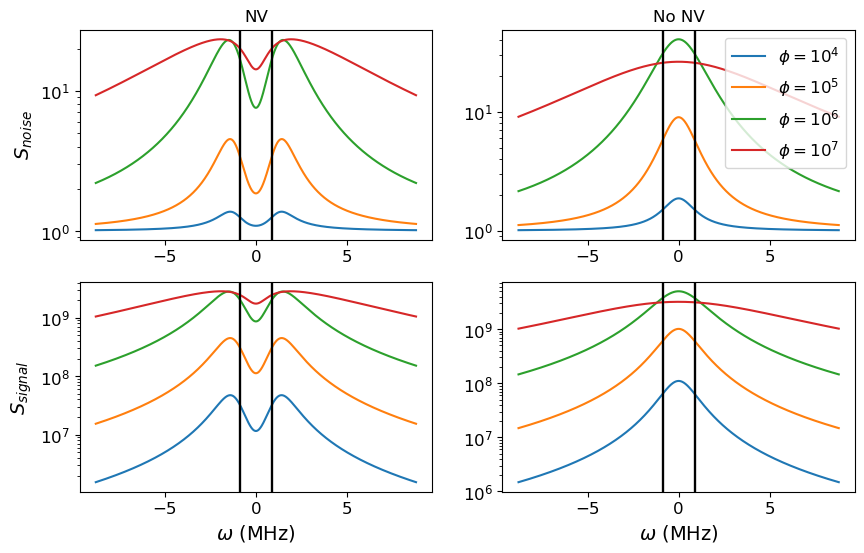

In [30]:
# Let's look at the spectra first
ϕ_vals = [1e4, 1e5, 1e6, 1e7]
s_noise_out_vals = []
s_signal_out_vals = []
s_noise_out_no_NV_vals = []
s_signal_out_no_NV_vals = []
for p in ϕ_vals:
    s_noise_out_vals.append(get_output_noise_spectrum_e(10*ω_bounds, κ, γ, p, g, r, nT, nc, β, Sϕ))
    s_signal_out_vals.append(get_output_signal_spectrum_e(10*ω_bounds, κ, γ, p, g, r, nT, nc, β))
    s_noise_out_no_NV_vals.append(get_output_noise_spectrum_e_no_NV(10*ω_bounds, κ, γ, p, nT, β, Sϕ))
    s_signal_out_no_NV_vals.append(get_output_signal_spectrum_e_no_NV(10*ω_bounds, κ, γ, p, nT, β))

#linestyles = ['-', (0, (5, 10)), (0, (5, 7.5)), (0, (5, 5)), (0, (5, 2.5))] 
linestyles = ['-', '-', '-', '-']
fig = plt.figure(1, figsize=(10, 6))
ax = fig.subplots(2, 2)
for i, p in enumerate(ϕ_vals):
    ax[0][0].semilogy(10*ω_bounds / 1e6, s_noise_out_vals[i], linestyle=linestyles[i])
    ax[0][0].axvline(x=-γ/1e6, color='k')
    ax[0][0].axvline(x=γ/1e6, color='k')

    ax[0][1].semilogy(10*ω_bounds / 1e6, s_noise_out_no_NV_vals[i], linestyle=linestyles[i], label='$\\phi = 10^{' + str(i+4) + '}$')
    ax[0][1].axvline(x=-γ/1e6, color='k')
    ax[0][1].axvline(x=γ/1e6, color='k')

    ax[1][0].semilogy(10*ω_bounds / 1e6, s_signal_out_vals[i], linestyle=linestyles[i])
    ax[1][0].axvline(x=-γ/1e6, color='k')
    ax[1][0].axvline(x=γ/1e6, color='k')

    ax[1][1].semilogy(10*ω_bounds / 1e6, s_signal_out_no_NV_vals[i], linestyle=linestyles[i])
    ax[1][1].axvline(x=-γ/1e6, color='k')
    ax[1][1].axvline(x=γ/1e6, color='k')

ax[0][0].set_ylabel("$S_{noise}$")
ax[0][0].set_title("NV")
ax[0][1].set_title("No NV")
ax[0][1].legend()
ax[1][0].set_ylabel("$S_{signal}$")
ax[1][0].set_xlabel("$\\omega$ (MHz)")
ax[1][1].set_xlabel("$\\omega$ (MHz)")

In [31]:
# Define ϕ values
ϕ_vals = np.logspace(4, 7, 1000)

In [32]:
# Define the input noise
input_noise = (ω_bounds[-1] - ω_bounds[0]) * (2*nT+1)
input_noise += integrate.simpson(Sϕ, x=ω_bounds)

# Define the input signal
input_signal = np.abs(β) ** 2

# Calculate the input snr
input_snr = input_signal / input_noise

In [33]:
# Calculate the output noise and signal for each κ value with no NV ensemble
output_noise_no_NV_vals = np.zeros(ϕ_vals.shape[0])
output_signal_no_NV_vals = np.zeros(ϕ_vals.shape[0])
for i, p in enumerate(ϕ_vals):
    temp = get_photons_e_no_NV(ω_bounds, κ, γ, p, nT, β, Sϕ)
    output_noise_no_NV_vals[i] = temp[0]
    output_signal_no_NV_vals[i] = temp[1]

# Calculate SNR
output_snr_no_NV_vals = output_signal_no_NV_vals / output_noise_no_NV_vals

In [34]:
# Calculate the output noise and signal for each κ value with NV ensemble
output_noise_vals = np.zeros(ϕ_vals.shape[0])
output_signal_vals = np.zeros(ϕ_vals.shape[0])
for i, p in enumerate(ϕ_vals):
    temp = get_photons_e(ω_bounds, κ, γ, p, g, r, nT, nc, β, Sϕ)
    output_noise_vals[i] = temp[0]
    output_signal_vals[i] = temp[1]

# Calculate SNR
output_snr_vals = output_signal_vals / output_noise_vals

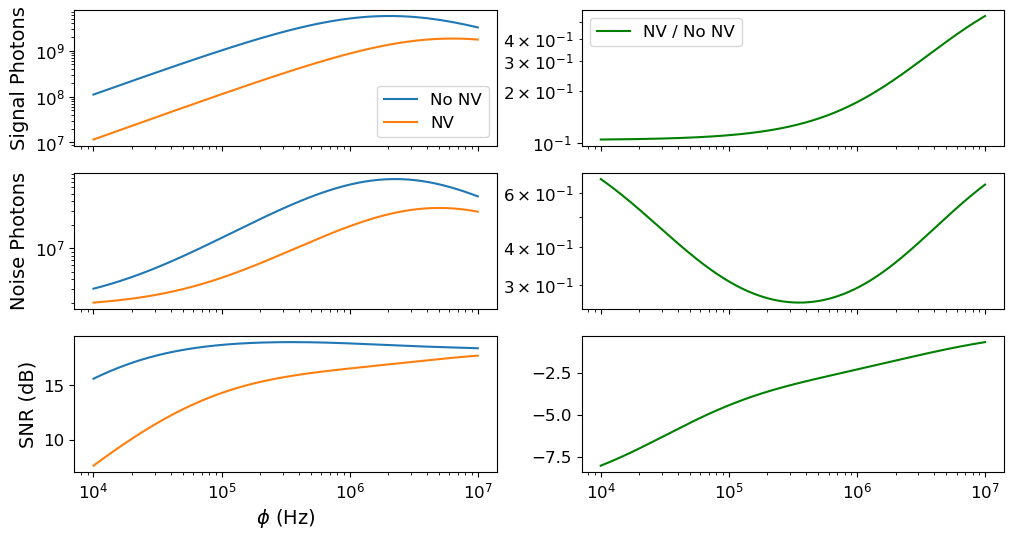

In [35]:
# Plot
fig = plt.figure(1, figsize=(12,6))
ax = fig.subplots(3, 2, sharex='all')
ax[0][0].semilogx(ϕ_vals, output_signal_no_NV_vals, label='No NV')
ax[0][0].semilogx(ϕ_vals, output_signal_vals, label='NV')
ax[0][0].set_ylabel("Signal Photons")
ax[0][0].set_yscale('log')
ax[0][0].legend()

ax[0][1].semilogx(ϕ_vals, output_signal_vals / output_signal_no_NV_vals, 'g-', label='NV / No NV')
ax[0][1].set_yscale('log')
ax[0][1].legend()

ax[1][0].semilogx(ϕ_vals, output_noise_no_NV_vals)
ax[1][0].semilogx(ϕ_vals, output_noise_vals)
ax[1][0].set_ylabel("Noise Photons")
ax[1][0].set_yscale('log')

ax[1][1].semilogx(ϕ_vals, output_noise_vals / output_noise_no_NV_vals, 'g-')
ax[1][1].set_yscale('log')

ax[2][0].semilogx(ϕ_vals, 10*np.log10(output_snr_no_NV_vals))
ax[2][0].semilogx(ϕ_vals, 10*np.log10(output_snr_vals))
ax[2][0].set_ylabel("SNR (dB)")
ax[2][0].set_xlabel("$\\phi$ (Hz)")

ax[2][1].semilogx(ϕ_vals, 10*np.log10(output_snr_vals / output_snr_no_NV_vals), 'g-')

### d) What about changing g and r?

Text(0.5, 0, '$\\omega$ (MHz)')

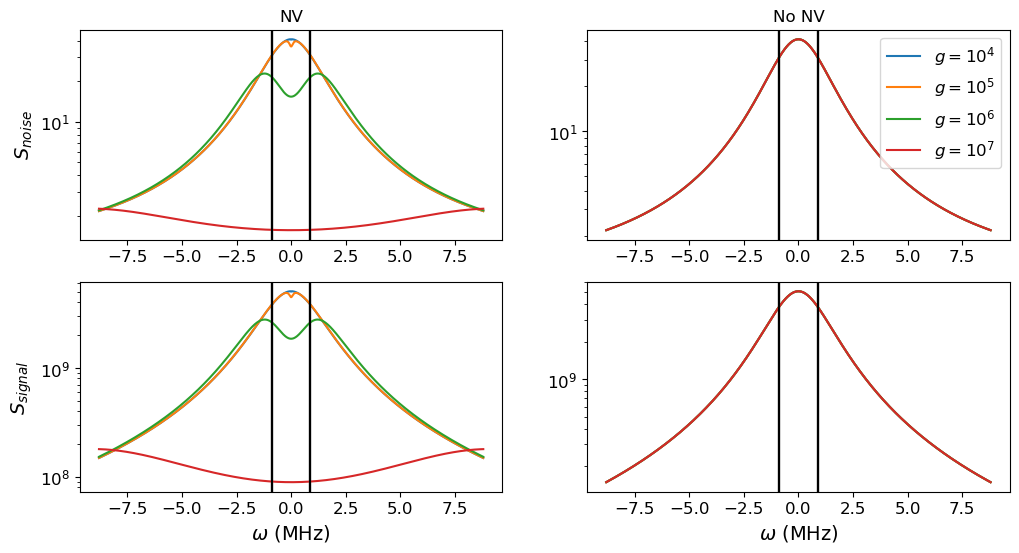

In [36]:
# Let's look at the spectra first
g_vals = [1e4, 1e5, 1e6, 1e7]
s_noise_out_vals = []
s_signal_out_vals = []
s_noise_out_no_NV_vals = []
s_signal_out_no_NV_vals = []
for g in g_vals:
    s_noise_out_vals.append(get_output_noise_spectrum_e(10*ω_bounds, κ, γ, ϕ, g, 2*g, nT, nc, β, Sϕ))
    s_signal_out_vals.append(get_output_signal_spectrum_e(10*ω_bounds, κ, γ, ϕ, g, 2*g, nT, nc, β))
    s_noise_out_no_NV_vals.append(get_output_noise_spectrum_e_no_NV(10*ω_bounds, κ, γ, ϕ, nT, β, Sϕ))
    s_signal_out_no_NV_vals.append(get_output_signal_spectrum_e_no_NV(10*ω_bounds, κ, γ, ϕ, nT, β))

#linestyles = ['-', (0, (5, 10)), (0, (5, 7.5)), (0, (5, 5)), (0, (5, 2.5))] 
linestyles = ['-', '-', '-', '-']
fig = plt.figure(1, figsize=(12, 6))
ax = fig.subplots(2, 2)
for i, g in enumerate(g_vals):
    ax[0][0].semilogy(10*ω_bounds / 1e6, s_noise_out_vals[i], linestyle=linestyles[i])
    ax[0][0].axvline(x=-γ/1e6, color='k')
    ax[0][0].axvline(x=γ/1e6, color='k')

    ax[0][1].semilogy(10*ω_bounds / 1e6, s_noise_out_no_NV_vals[i], linestyle=linestyles[i], label='$g = 10^{' + str(i+4) + '}$')
    ax[0][1].axvline(x=-γ/1e6, color='k')
    ax[0][1].axvline(x=γ/1e6, color='k')

    ax[1][0].semilogy(10*ω_bounds / 1e6, s_signal_out_vals[i], linestyle=linestyles[i])
    ax[1][0].axvline(x=-γ/1e6, color='k')
    ax[1][0].axvline(x=γ/1e6, color='k')

    ax[1][1].semilogy(10*ω_bounds / 1e6, s_signal_out_no_NV_vals[i], linestyle=linestyles[i])
    ax[1][1].axvline(x=-γ/1e6, color='k')
    ax[1][1].axvline(x=γ/1e6, color='k')

ax[0][0].set_ylabel("$S_{noise}$")
ax[0][0].set_title("NV")
ax[0][1].set_title("No NV")
ax[0][1].legend()
ax[1][0].set_ylabel("$S_{signal}$")
ax[1][0].set_xlabel("$\\omega$ (MHz)")
ax[1][1].set_xlabel("$\\omega$ (MHz)")

In [37]:
# Define g and r
g_vals = np.logspace(4, 7, 1000)
r_vals = 2 * g_vals

In [38]:
# Define the input noise
input_noise = (ω_bounds[-1] - ω_bounds[0]) * (2*nT+1)
input_noise += integrate.simpson(Sϕ, x=ω_bounds)

# Define the input signal
input_signal = np.abs(β) ** 2

# Calculate the input snr
input_snr = input_signal / input_noise

In [39]:
# The output snr for the cavity without the NV ensemble won't change here
output_noise_no_NV_vals, output_signal_no_NV_vals, total = get_photons_e_no_NV(ω_bounds, κ, γ, ϕ, nT, β, Sϕ)
output_snr_no_NV_vals = output_signal_no_NV_vals / output_noise_no_NV_vals

In [40]:
# Now calculate the output noise and signal for the case with the NV ensemble
output_noise_vals = np.zeros(g_vals.shape[0])
output_signal_vals = np.zeros(g_vals.shape[0])
for i in range(g_vals.shape[0]):
    temp = get_photons_e(ω_bounds, κ, γ, ϕ, g_vals[i], r_vals[i], nT, nc, β, Sϕ)
    output_noise_vals[i] = temp[0]
    output_signal_vals[i] = temp[1]

output_snr_vals = output_signal_vals / output_noise_vals

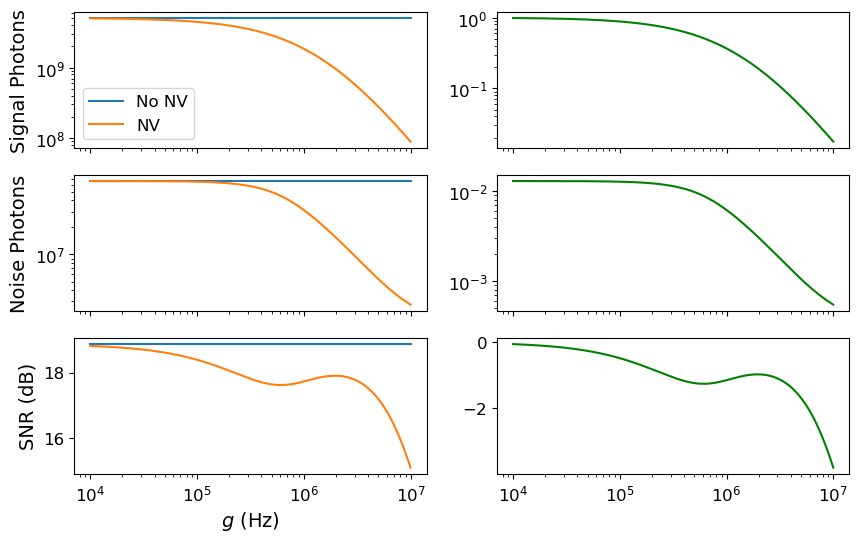

In [41]:
fig = plt.figure(1, figsize=(10,6))
ax = fig.subplots(3, 2, sharex='all')
ax[0][0].semilogx(g_vals, output_signal_no_NV_vals * np.ones(g_vals.shape[0]), label='No NV')
ax[0][0].semilogx(g_vals, output_signal_vals, label='NV')
ax[0][0].set_ylabel("Signal Photons")
ax[0][0].set_yscale('log')
ax[0][0].legend()

ax[0][1].semilogx(g_vals, output_signal_vals / output_signal_no_NV_vals, 'g-', label='NV / No NV')
ax[0][1].set_yscale('log')

ax[1][0].semilogx(g_vals, output_noise_no_NV_vals * np.ones(g_vals.shape[0]))
ax[1][0].semilogx(g_vals, output_noise_vals)
ax[1][0].set_ylabel("Noise Photons")
ax[1][0].set_yscale('log')

ax[1][1].semilogx(g_vals, output_noise_vals / output_signal_no_NV_vals, 'g-')
ax[1][1].set_yscale('log')

ax[2][0].semilogx(g_vals, 10*np.log10(output_snr_no_NV_vals) * np.ones(g_vals.shape[0]))
ax[2][0].semilogx(g_vals, 10*np.log10(output_snr_vals))
ax[2][0].set_ylabel("SNR (dB)")
ax[2][0].set_xlabel("$g$ (Hz)")

ax[2][1].semilogx(g_vals, 10*np.log10(output_snr_vals / output_snr_no_NV_vals), 'g-')

### Want to double check that the integration function is matching what I have done by hand

In [42]:
# Define parameters
ωc = 2.87 * 2 * np.pi * 1e9
g = 2 * np.pi * 197.7e3
r = 2 * np.pi * 229e3
γ = 2 * np.pi * 140e3
κ = 2 * np.pi * 185.1e3
P = 0.8
nc = 0.5 * (1 - P) / P
T = 5
nT = photons_from_temp(ωc, T)
ϕ = (κ + γ) / 2
β = np.sqrt(1e10)

In [43]:
# Define simplified terms
b = r / 2
a = (κ + γ + ϕ) / 2
x = (ϕ - κ - γ) / 2

# Define combinations used in integration formula
B = a ** 2 + b ** 2 - 2 * g ** 2
C = a ** 2 * b ** 2 + 2 * a * b * g ** 2 + g ** 4
D = np.sqrt(B ** 2 - 4 * C)
E = x ** 2 * b ** 2 - 2 * x * b * g ** 2 + g ** 4
F = x ** 2 + b ** 2 - 2 * g ** 2

/tmp/ipykernel_194807/3643513297.py:9: RuntimeWarning: invalid value encountered in sqrt
  D = np.sqrt(B ** 2 - 4 * C)


In [44]:
n_e_exact_1 = 2 * np.arctan(np.sqrt(2) * γ / np.sqrt(B - D)) / (D * np.sqrt(2) * np.sqrt(B - D))
n_e_exact_1 *= (ϕ * (κ + γ) * nT * (2 * b ** 2 + D - B) + 2 * ϕ * r * g ** 2 * nc + F * D - B * D + B ** 2 - B * F - 2 * C + 2 * E)

n_e_exact_2 = 2 * np.arctan(np.sqrt(2) * γ / np.sqrt(B + D)) / (D * np.sqrt(2) * np.sqrt(B + D))
n_e_exact_2 *= (ϕ * (κ + γ) * nT * (-2 * b ** 2 + D + B) - 2 * ϕ * r * g ** 2 * nc + F * D - B * D - B ** 2 + B * F + 2 * C - 2 * E)

n_e_exact = n_e_exact_1 + n_e_exact_2 + 2 * γ

In [45]:
ω_bounds = np.linspace(-γ, γ, 1000)
n_e_calc, s_e_calc, tot = get_photons_e(ω_bounds, κ, γ, ϕ, g, r, nT, nc, β, Sϕ)

In [46]:
n_e_exact, n_e_calc, np.allclose(n_e_exact, n_e_calc)

(np.float64(nan), np.float64(19332361.93514373), False)

In [47]:
s_e_exact = b ** 2 * ϕ * κ / C * np.abs(β) ** 2

In [48]:
s_e_exact, s_e_calc, np.allclose(s_e_exact, s_e_calc)

(np.float64(878643288.643315), np.float64(878643288.6433148), True)

In [49]:
sout_e = get_output_spectrum_e(ω_bounds, κ, γ, ϕ, g, r, nT, nc, β, Sϕ)

Text(0, 0.5, '$S_{out}(\\omega)$')

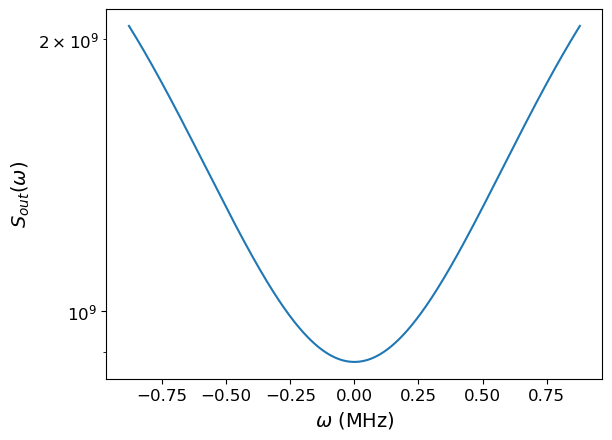

In [50]:
plt.semilogy(ω_bounds / (1e6), sout_e)
plt.xlabel("$\\omega$ (MHz)")
plt.ylabel("$S_{out}(\\omega)$")

In [51]:
integrate.simpson(sout_e, x=ω_bounds)

np.float64(2286478236615389.0)

In [52]:
# Calculate the spectrum at different values of g
ω_bounds = np.linspace(-100*γ, 100*γ, 1000)
g_vals = [1e3, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9]
s_noise_outs = []
s_signal_outs = []
for G in g_vals:
    s_noise_outs.append(get_output_noise_spectrum_e(ω_bounds, κ, γ, ϕ, G, 2*G, nT, nc, β, Sϕ))
    s_signal_outs.append(get_output_signal_spectrum_e(ω_bounds, κ, γ, ϕ, G, 2*G, nT, nc, β))

Text(0, 0.5, '$S_{signal}(\\omega)$')

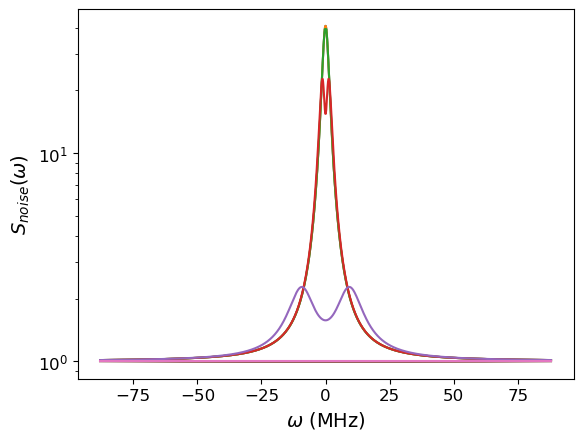

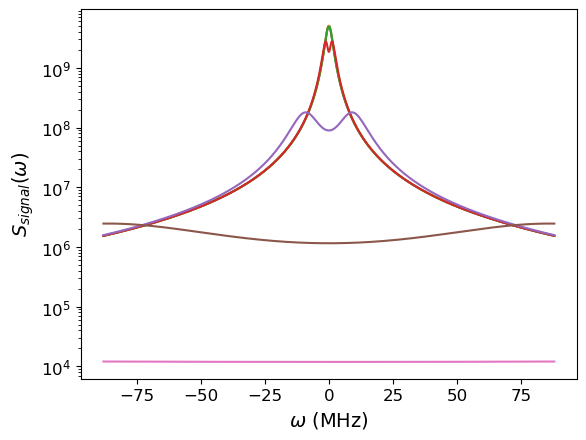

In [53]:
plt.figure(1)
for i, g in enumerate(g_vals):
    plt.semilogy(ω_bounds / 1e6, s_noise_outs[i])#, label='$g=10^{' + str(i+5) + '}$')
plt.xlabel("$\\omega$ (MHz)")
plt.ylabel("$S_{noise}(\\omega)$")

plt.figure(2)
for i, g in enumerate(g_vals):
    plt.semilogy(ω_bounds / 1e6, s_signal_outs[i])
plt.xlabel("$\\omega$ (MHz)")
plt.ylabel("$S_{signal}(\\omega)$")

Text(0, 0.5, '$S_{signal}(\\omega)$')

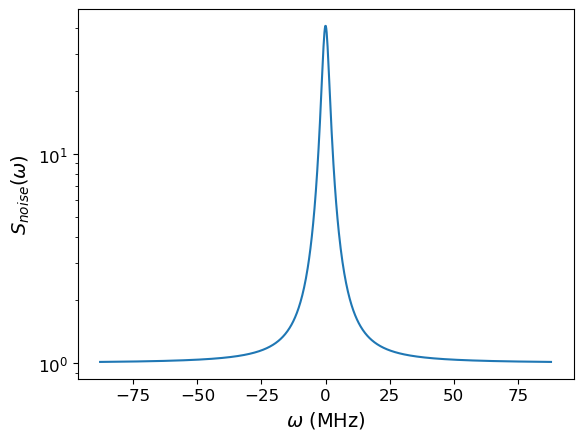

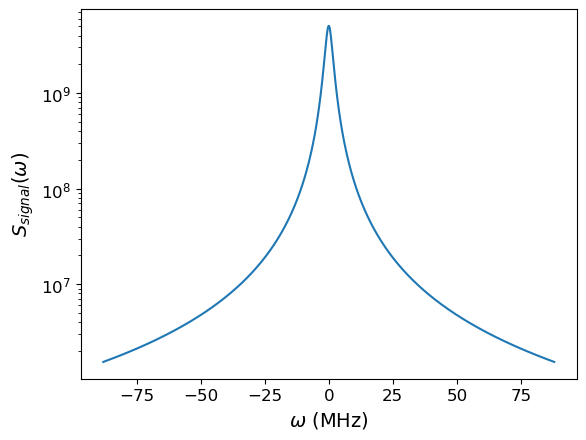

In [54]:
# Output spectra with no NV
s_noise_out_no_NV = get_output_noise_spectrum_e_no_NV(ω_bounds, κ, γ, ϕ, nT, β, Sϕ)
s_signal_out_no_NV = get_output_signal_spectrum_e_no_NV(ω_bounds, κ, γ, ϕ, nT, β)
plt.figure(1)
plt.semilogy(ω_bounds / 1e6, s_noise_out_no_NV)
plt.xlabel("$\\omega$ (MHz)")
plt.ylabel("$S_{noise}(\\omega)$")

plt.figure(2)
plt.semilogy(ω_bounds / 1e6, s_signal_out_no_NV)
plt.xlabel("$\\omega$ (MHz)")
plt.ylabel("$S_{signal}(\\omega)$")

In [55]:
bare_coeff_nT = ϕ*(κ+γ) / np.abs(((κ+γ+ϕ) / 2 - 1j * ω_bounds)) ** 2
nv_coeff_nT = ϕ * (κ + γ) * (r ** 2 / 4 + ω_bounds ** 2) / np.abs(((κ+γ+ϕ) / 2 - 1j * ω_bounds) * (r / 2 - 1j * ω_bounds) + g**2) ** 2

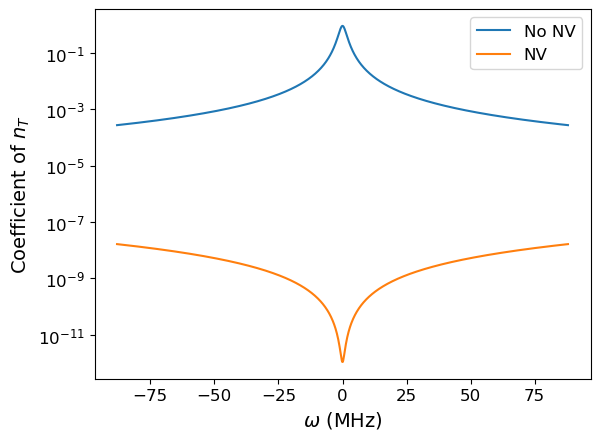

In [56]:
plt.semilogy(ω_bounds / 1e6, bare_coeff_nT, label='No NV')
plt.semilogy(ω_bounds / 1e6, nv_coeff_nT, label='NV')
plt.xlabel("$\\omega$ (MHz)")
plt.ylabel("Coefficient of $n_T$")
plt.legend()

In [57]:
bare_coeff_nv = np.abs((ϕ - κ - γ) / 2 + 1j * ω_bounds) ** 2 / np.abs((κ+γ+ϕ) / 2 - 1j * ω_bounds) ** 2
nv_coeff_nv = np.abs(((ϕ - κ - γ) / 2 + 1j * ω_bounds) * (r / 2 - 1j * ω_bounds) - g ** 2) ** 2 / np.abs(((κ+γ+ϕ) / 2 - 1j * ω_bounds) * (r / 2 - 1j * ω_bounds) + g**2) ** 2

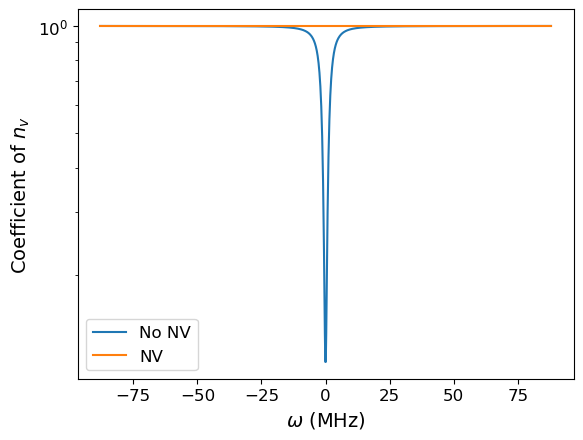

In [58]:
plt.semilogy(ω_bounds / 1e6, bare_coeff_nv, label='No NV')
plt.semilogy(ω_bounds / 1e6, nv_coeff_nv, label='NV')
plt.xlabel("$\\omega$ (MHz)")
plt.ylabel("Coefficient of $n_v$")
plt.legend()

Let's double-check to make sure that the noise terms all add up to the initial noise.  The signal terms should all add up to the initial signal as well.

In [59]:
# Calculate the terms for the no NV case
ne_no_NV, se_no_NV, tote_no_NV = get_photons_e_no_NV(ω_bounds, κ, γ, ϕ, nT, β, 0)
na_no_NV, sa_no_NV, tota_no_NV = get_photons_a_no_NV(ω_bounds, κ, γ, ϕ, nT, β, 0)
nb_no_NV, sb_no_NV, totb_no_NV = get_photons_b_no_NV(ω_bounds, κ, γ, ϕ, nT, β, 0)

In [60]:
# Calculate the terms for the NV case
ne, se, tote = get_photons_e(ω_bounds, κ, γ, ϕ, r, g, nT, nc, β, 0)
na, sa, tota = get_photons_a(ω_bounds, κ, γ, ϕ, r, g, nT, nc, β, 0)
nb, sb, totb = get_photons_b(ω_bounds, κ, γ, ϕ, r, g, nT, nc, β, 0)
n_nv, sc, totc = get_photons_c(ω_bounds, κ, γ, ϕ, r, g, nT, nc, β, 0)

In [61]:
# Print noise terms for the no NV case
print("------ Noise ------")
print("Transmitted noise: ", ne_no_NV)
print("Reflected noise: ", na_no_NV)
print("Loss noise: ", nb_no_NV)
print("Total: ", ne_no_NV + nb_no_NV + na_no_NV)
print("Input: ", (2 * nT + 1) * (ω_bounds[-1] - ω_bounds[0]))# + integrate.simpson(0, x=ω_bounds))
print("")
print("------ Signal ------")
print("Transmitted: ", se_no_NV)
print("Reflected: ", sa_no_NV)
print("Loss: ", sb_no_NV)
print("Total: ", se_no_NV + sa_no_NV + sb_no_NV)
print("Input: ", np.abs(β) ** 2)

------ Noise ------
Transmitted noise:  323155470.4161832
Reflected noise:  6214330502.71479
Loss noise:  6234754696.22406
Total:  12772240669.355034
Input:  12772240669.355034

------ Signal ------
Transmitted:  5061006869.681124
Reflected:  580082261.3225223
Loss:  4358910868.996353
Total:  10000000000.0
Input:  10000000000.0


In [62]:
# Print noise terms for the NV case
print("------ Noise ------")
print("Transmitted noise: ", ne)
print("Reflected noise: ", na)
print("Loss noise: ", nb)
print("NV ensemble: ", n_nv)
print("Total: ", ne + nb + na + n_nv)
print("Input: ", (2 * nT + 1 + nc) * (ω_bounds[-1] - ω_bounds[0]))# + integrate.simpson(0, x=ω_bounds))
print("")
print("------ Signal ------")
print("Transmitted: ", se)
print("Reflected: ", sa)
print("Loss: ", sb)
print("NV: ", sc)
print("Total: ", se + sa + sb + sc)
print("Input: ", np.abs(β) ** 2)

------ Noise ------
Transmitted noise:  322740425.38810587
Reflected noise:  6213863660.951335
Loss noise:  6234401601.42728
NV ensemble:  23226130.16344097
Total:  12794231817.93016
Input:  12794231817.930162

------ Signal ------
Transmitted:  5033760313.47501
Reflected:  589980874.3214369
Loss:  4335444133.414343
NV:  40814678.78921121
Total:  10000000000.0
Input:  10000000000.0
